In [248]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
warnings.filterwarnings('ignore')
import re
from collections import Counter
from statistics import mode
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [249]:
path  = 'C:/Users/ntste/Documents/Personal/Kaggle/titanic_proj/titanic/'
train = pd.read_csv(path + 'train.csv')
test  = pd.read_csv(path + 'test.csv')
train_original = train.copy()

In [250]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [251]:
print(train.dtypes)

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


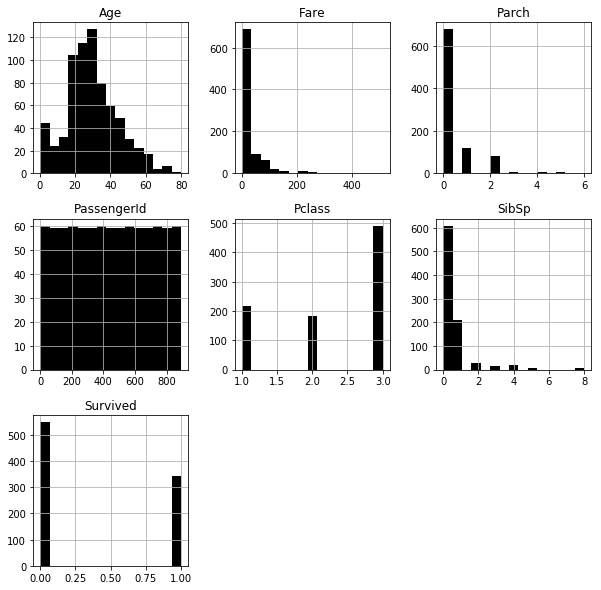

In [252]:
train.hist(figsize=(10,10), color = 'black', bins = 15)
plt.show()

In [253]:
#Print proportion of males and females who survived
prop_male_s   = train['Survived'][train['Sex'] == 'male'].value_counts(normalize = True)[1]
prop_female_s = train['Survived'][train['Sex'] == 'female'].value_counts(normalize = True)[1]
print('Male survival proportion:', prop_male_s)
print('Female survival proportion:', prop_female_s)

Male survival proportion: 0.18890814558058924
Female survival proportion: 0.7420382165605095


In [254]:
#Print proportion survival by class
prop_first_s  = train['Survived'][train['Pclass'] == 1].value_counts(normalize = True)[1]
prop_second_s = train['Survived'][train['Pclass'] == 2].value_counts(normalize = True)[1]
prop_third_s  = train['Survived'][train['Pclass'] == 3].value_counts(normalize = True)[1]
print('Proportion of 1st class who survived:', prop_first_s)
print('Proportion of 2nd class who survived:', prop_second_s)
print('Proportion of 3rd class who survived:', prop_third_s)

Proportion of 1st class who survived: 0.6296296296296297
Proportion of 2nd class who survived: 0.47282608695652173
Proportion of 3rd class who survived: 0.24236252545824846


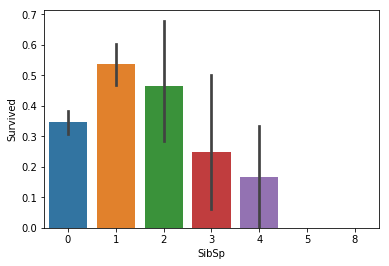

In [255]:
#Look at survival rates by number of siblings/spouses
sns.barplot(x="SibSp", y="Survived", data=train)

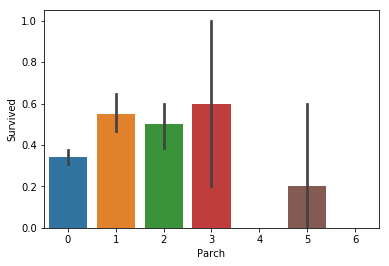

In [256]:
#Look at survival rates by number of parents/children
sns.barplot(x="Parch", y="Survived", data=train)

In [257]:
full_dataset = pd.concat([train, test], sort=False, ignore_index=True)

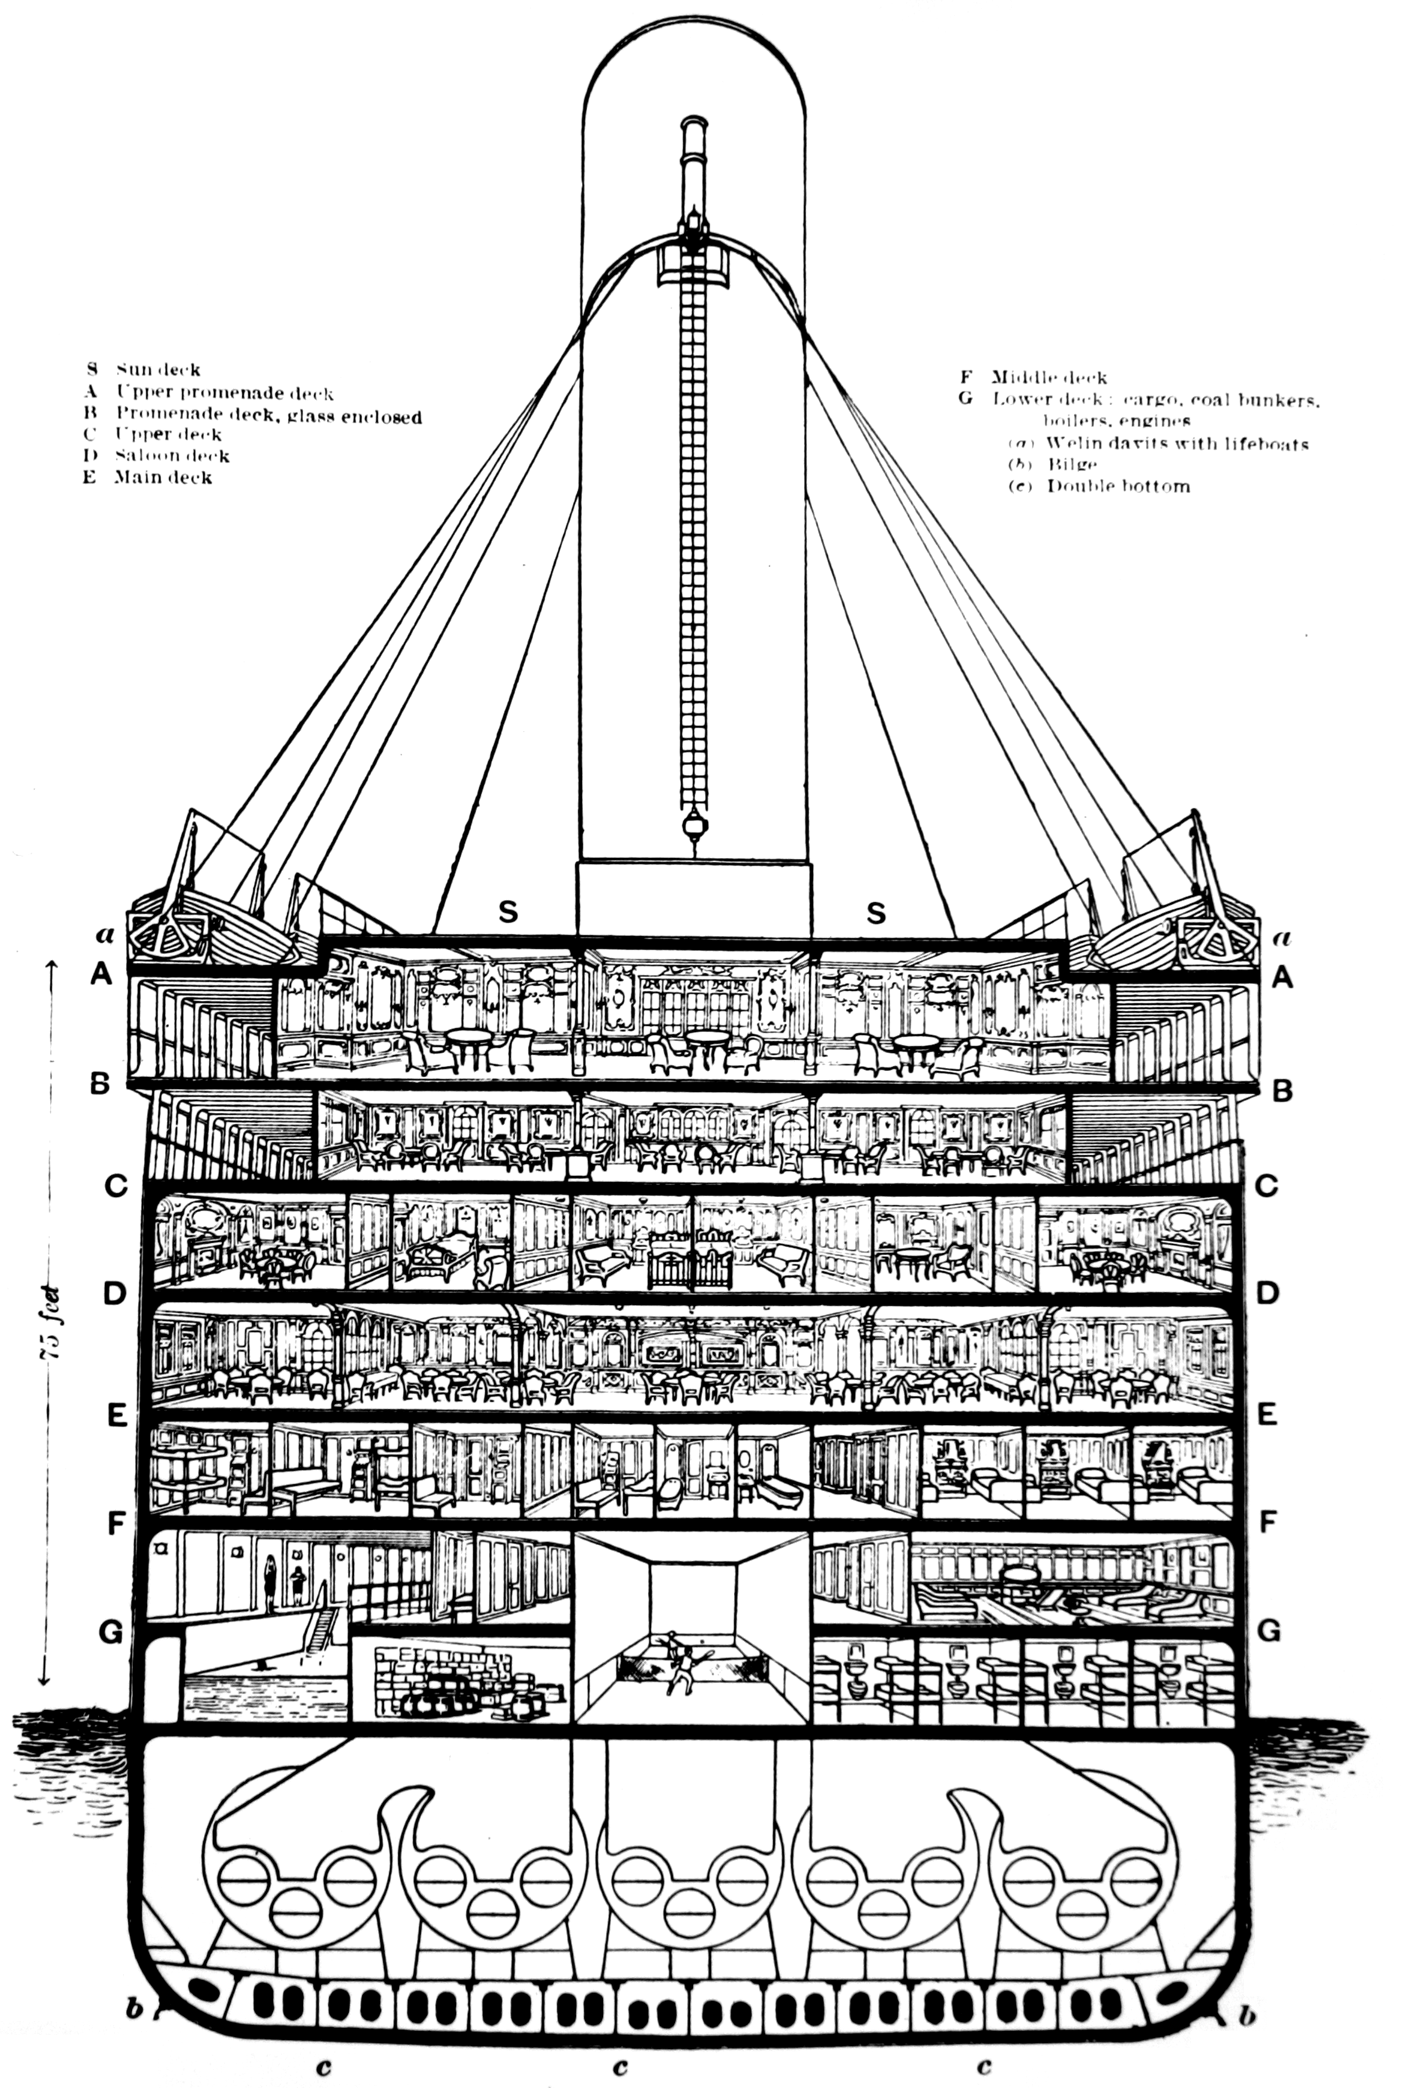

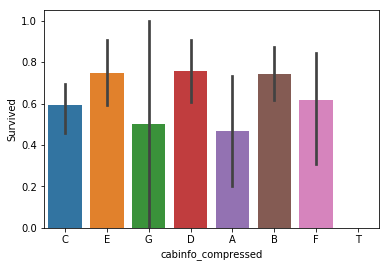

In [258]:
"""
A deck: First class cabins 
A-Deck is accessible via the Boat Deck forward by using a set of 
exterior stairs and via the Grand Staircase and Aft Grand Staircase 
and Lifts.

B deck: First class and private promenades
B-Deck is accessible via the forward and aft Grand Staircase and Lifts. 
It can also be accessed via the Cargo Hold, which has an exit out onto 
the well deck, and A-Deck forward, which has a staircase leading down 
onto the well deck.

C deck: First class staterooms and some crew cabins
C-Deck is accessible via the Grand Staircase and the Aft Grand Staircase. 
The Second Class Stairwell does not have an exit on C-Deck.

D deck: Large public rooms and mixed classes

F deck: second and third class cabins

G deck: crew
"""
full_dataset['cabinfo_compressed'] = full_dataset['Cabin'].dropna().astype(str).str[0]
sns.barplot(x = "cabinfo_compressed", y = "Survived", data = full_dataset)

In [259]:
full_dataset.isnull().mean().sort_values()

PassengerId           0.000000
Pclass                0.000000
Name                  0.000000
Sex                   0.000000
SibSp                 0.000000
Parch                 0.000000
Ticket                0.000000
Fare                  0.000764
Embarked              0.001528
Age                   0.200917
Survived              0.319328
Cabin                 0.774637
cabinfo_compressed    0.774637
dtype: float64

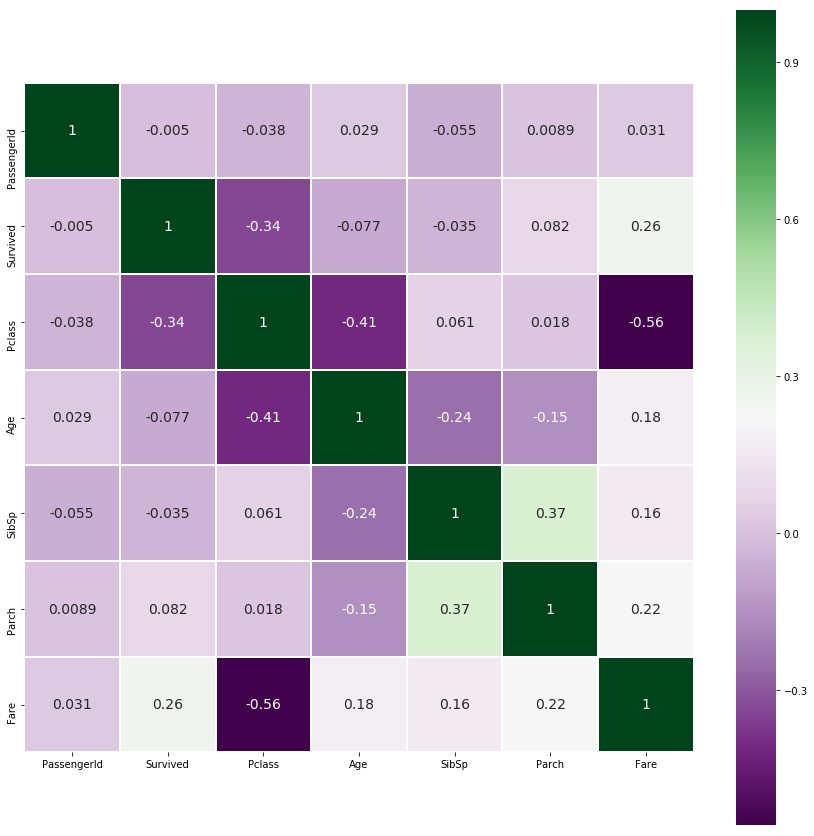

In [260]:
fig,ax = plt.subplots(nrows=1, figsize=(15,15))
sns.heatmap(full_dataset.corr(), annot = True, annot_kws={'size':14}, cmap = 'PRGn',square = True, linewidths = 1)

In [261]:
#Fill missing values.

#Replace missing fares with mean of that class.
first_fare  = full_dataset['Fare'][full_dataset['Pclass'] == 1].mean()
second_fare = full_dataset['Fare'][full_dataset['Pclass'] == 2].mean()
third_fare  = full_dataset['Fare'][full_dataset['Pclass'] == 3].mean()
print(first_fare, second_fare,third_fare)
full_dataset['Fare'].fillna(-5, inplace = True)

for index in range(full_dataset.shape[0]):
    if (full_dataset.iloc[index][2] == 1) and (full_dataset.iloc[index][9] == -5.0):
        full_dataset.at[index,'Fare'] = first_fare
        #full_dataset.loc[index][9] = first_fare
    elif (full_dataset.iloc[index][2] == 2) and (full_dataset.iloc[index][9] == -5.0):
        #full_dataset.loc[index][9] = second_fare 
        full_dataset.at[index,'Fare'] = second_fare
    elif (full_dataset.iloc[index][2] == 3) and (full_dataset.iloc[index][9] == -5.0):
        #full_dataset.loc[index][9] = third_fare
        full_dataset.at[index,'Fare'] = third_fare

#Replace embarked with mode (S)
full_dataset['Embarked'].fillna('S')

#For now, fill in missing ages with mean
#full_dataset['Age'].fillna(full_dataset['Age'].mean(), inplace = True)

#Unclear what to do with ticket information, so dropping it
full_dataset.drop(['Ticket'], axis = 1, inplace = True)

#Cabin is missing most values and there isn't a clear correlation between
#cabin and survival, so dropping it.
full_dataset.drop(['Cabin'], axis = 1, inplace = True)
full_dataset.drop(['cabinfo_compressed'], axis = 1, inplace = True)

87.5089916408668 21.1791963898917 13.302888700564969


In [262]:
#Create enhanced feature from names to use title as class indicator

#First extract titles
full_dataset['Title'] = full_dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand = False)
full_dataset['Title'].value_counts(normalize = True) * 100

#Combine some of the less common titles
#Mlle and Ms --> Miss, Mme --> Mrs
#Jonkheer and Don are equivalent to Lord
#Anying with less than 1% represntation considered uncommon
full_dataset['Title'] = full_dataset['Title'].replace(['Dr','Rev','Col','Major','Sir','Lady','Don','Jonkheer','Countess','Dona','Capt'],'Uncommon')
full_dataset['Title'] = full_dataset['Title'].replace(['Mlle','Ms'], 'Miss')
full_dataset['Title'] = full_dataset['Title'].replace(['Mme'], 'Mrs')

#Map values numerically
mapped_titles = {"Mr":1, "Miss":2, "Mrs":3, "Master":4, "Uncommon":5}
full_dataset['Title'] = full_dataset['Title'].map(mapped_titles)
full_dataset.isnull().mean().sort_values()

#Drop the name feature
full_dataset.drop(['Name'], axis = 1, inplace = True)

In [263]:
#Created enhanced feature to denote family size
full_dataset['FamSize'] = full_dataset['SibSp'] + full_dataset['Parch']

In [264]:
#Encode labels
full_dataset['Embarked'] = full_dataset['Embarked'].astype(str)
label = LabelEncoder()
for col in ['Sex','Embarked']:
    full_dataset[col] = label.fit_transform(full_dataset[col])
full_dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamSize
0,1,0.0,3,1,22.0,1,0,7.2500,2,1,1
1,2,1.0,1,0,38.0,1,0,71.2833,0,3,1
2,3,1.0,3,0,26.0,0,0,7.9250,2,2,0
3,4,1.0,1,0,35.0,1,0,53.1000,2,3,1
4,5,0.0,3,1,35.0,0,0,8.0500,2,1,0


In [265]:
#Split back into test and train sets
train.head()
train = full_dataset[:len(train)]
test  = full_dataset[len(train):]
train['Survived'] = train['Survived'].astype(int)
test.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamSize
891,892,NaN,3,1,34.5,0,0,7.8292,1,1,0
892,893,NaN,3,0,47.0,1,0,7.0000,2,3,1
893,894,NaN,2,1,62.0,0,0,9.6875,1,1,0
894,895,NaN,3,1,27.0,0,0,8.6625,2,1,0
895,896,NaN,3,0,22.0,1,1,12.2875,2,3,2


In [241]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

y = train['Survived']
x = train.drop(['Survived'],axis = 1)

In [242]:
scores = cross_val_score(LogisticRegression(),x,y)
#mean and 95% CI:
print("Logistic regression accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

scores = cross_val_score(SVC(),x,y)
#mean and 95% CI:
print("SVC accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

scores = cross_val_score(DecisionTreeClassifier(),x,y)
#mean and 95% CI:
print("Decision tree clissifier accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

scores = cross_val_score(GradientBoostingClassifier(),x,y)
#mean and 95% CI:
print("Gradient boosting classifier accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

Logistic regression accuracy: 0.805 (+/- 0.024)
SVC accuracy: 0.615 (+/- 0.003)
Decision tree clissifier accuracy: 0.652 (+/- 0.160)
Gradient boosting classifier accuracy: 0.734 (+/- 0.117)


In [244]:
#We will train w/ logistic regression because it has the best cross-val score
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,random_state = 10)

y_train = label_enc.fit_transform(y_train)
y_test  = label_enc.fit_transform(y_test)
lr_mod  = LogisticRegression()
model   = lr_mod.fit(x_train,y_train)
y_predict = lr_mod.predict(x_test)

print('R^2: ', lr_mod.score(x_train,y_train))
print('R^2: ', lr_mod.score(x_test,y_test))

predicted_survival = lr_mod.predict(test.drop(['Survived'], axis = 1))
test['Survived'] = predicted_survival #Score: .76555

output = test[['PassengerId','Survived']]
output.to_csv('C:/Users/ntste/Documents/Personal/Kaggle/titanic_proj/titanic/my_gender_submission_meanage.csv', index = False)

R^2:  0.8019662921348315
R^2:  0.8491620111731844


In [270]:
#Can we improve the accuracy of our age estimates?
#Previously we calculated age with the mean.

#First grab portion of data where age is known
age_known   = full_dataset.loc[full_dataset['Age'].isnull() == False]
age_unknown = full_dataset.loc[full_dataset['Age'].isnull()]

train_copy  = age_known.copy()
train_set   = train_copy.sample(frac=0.8, random_state=0)
test_set    = train_copy.drop(train_set.index)
features    = ["Pclass", "Sex", "Embarked","FamSize"]
x_train     = pd.get_dummies(train_set[features])
x_test      = pd.get_dummies(test_set[features])
y_train     = train_set['Age']
y_test      = test_set['Age']


lr_mod  = LinearRegression()
model   = lr_mod.fit(x_train,y_train)
y_predict = lr_mod.predict(x_test)
print('R^2: ', lr_mod.score(x_train,y_train))
print('R^2: ', lr_mod.score(x_test,y_test))

predicted_ages = lr_mod.predict(age_unknown[features])
age_unknown['Age'] = predicted_ages

#Merge sets
final_dataset = age_known
final_dataset = final_dataset.append(age_unknown)

R^2:  0.20955512665382992
R^2:  0.27159680523790064


In [271]:
#We will train  again w/ logistic regression to classify survival
train = final_dataset.loc[full_dataset['Survived'].isnull() == False]
test  = final_dataset.loc[full_dataset['Survived'].isnull()]
y = train['Survived']
x = train.drop(['Survived'], axis = 1)

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,random_state = 10)
y_train = label_enc.fit_transform(y_train)
y_test  = label_enc.fit_transform(y_test)
lr_mod  = LogisticRegression()
model   = lr_mod.fit(x_train,y_train)
y_predict = lr_mod.predict(x_test)

print('R^2: ', lr_mod.score(x_train,y_train))
print('R^2: ', lr_mod.score(x_test,y_test))

predicted_survival = lr_mod.predict(test.drop(['Survived'], axis = 1))
test['Survived'] = predicted_survival #Score: .77511


R^2:  0.8132022471910112
R^2:  0.8044692737430168


In [272]:
output = test[['PassengerId','Survived']]
output.to_csv('C:/Users/ntste/Documents/Personal/Kaggle/titanic_proj/titanic/my_gender_submission.csv', index = False)